# Import required packages

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import os
import scipy.io.wavfile
import numpy as np
import sys
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization, Input, Flatten, Dropout, Activation
from keras.utils import to_categorical, np_utils
import live_plot
import fetch_label
from tqdm import notebook
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


## Reading audio data

In [3]:
Train_data_path = './Audio_Speech_Actors_01-24'
mylist = []
for path, subdirs, files in os.walk(Train_data_path):
    for name in files:
        mylist.append(os.path.join(path, name))

In [4]:
len(mylist)

1440

In [12]:
mylist[0]

'./Audio_Speech_Actors_01-24/Actor_09/03-01-07-01-02-01-09.wav'

Filename Identifiers:
    
1. Modality (01 = full-AV, 02 = video-only, 03 = audio-only).\
2. Vocal channel (01 = speech, 02 = song).\
3. Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).\
4. Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.\
5. Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).\
6. Repetition (01 = 1st repetition, 02 = 2nd repetition).\
7. Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).\

## Plotting audio file

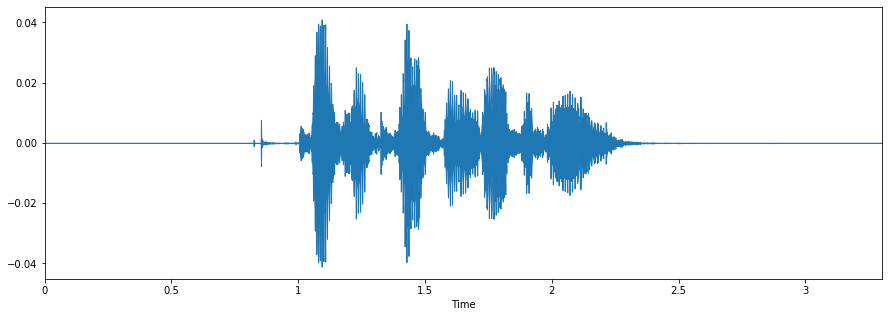

In [9]:
file_path='./Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav'
data, sampling_rate = librosa.load(file_path)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [11]:
sr,x = scipy.io.wavfile.read(file_path)
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()

/home/hs/Desktop/Projects/my_projects_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


ValueError: Incomplete wav chunk.

## Extract features from audio using librosa

In [120]:
mylist[0]

'./Audio_Speech_Actors_01-24/Actor_09/03-01-07-01-02-01-09.wav'

In [106]:
label = fetch_label.FetchLabel()
df = pd.DataFrame(columns=['feature','emotion'])
bookmark=0
for index,y in enumerate(notebook.tqdm(mylist)):
    X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    if len(feature)==259:
        print(mylist[index])
    emotion = label.get_emotion(y)
    #print(emotion)
    emotion=emotion.replace('female_', '')
    emotion=emotion.replace('male_', '')
    #print(emotion)
    df.loc[bookmark] = [feature, emotion]
    bookmark=bookmark+1        

./Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-01-01-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-07-01-01-02-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-02-01-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-04-02-01-01-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-01-02-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-03-01-01-02-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-07-02-01-02-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-05-01-01-02-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-05-01-02-01-09.wav
./Audio_Speech_Actors_01-24/Actor_09/03-01-04-02-02-01-09.wav


KeyboardInterrupt: 

In [102]:
df

,feature,emotion
0,"[-73.24139, -73.55329, -71.55998, -69.435104, ...",disgusted
1,"[-68.52591, -68.52591, -68.52591, -68.52591, -...",happy
2,"[-74.32096, -74.32096, -74.32096, -74.32096, -...",sad
3,"[-44.88586, -45.08242, -47.0765, -46.61029, -4...",happy
4,"[-70.07857, -70.97567, -73.16718, -65.0323, -6...",sad
...,...,...
1435,"[-59.211617, -58.68752, -59.09467, -59.007286,...",happy
1436,"[-63.73215, -63.73215, -63.73215, -63.73215, -...",sad
1437,"[-57.67239, -58.34681, -58.55408, -57.433388, ...",happy
1438,"[-63.410885, -63.410885, -63.410885, -63.41088...",disgusted


In [27]:
[len(x) for x in df['feature'].values]

[256,
 242,
 251,
 259,
 239,
 251,
 230,
 256,
 259,
 259,
 253,
 245,
 259,
 259,
 259,
 259,
 259,
 245,
 259,
 236,
 259,
 242,
 239,
 253,
 259,
 253,
 245,
 245,
 228,
 228,
 236,
 256,
 259,
 259,
 222,
 236,
 251,
 245,
 251,
 259,
 239,
 253,
 259,
 259,
 230,
 236,
 259,
 259,
 251,
 259,
 253,
 233,
 239,
 259,
 259,
 259,
 259,
 259,
 259,
 245,
 259,
 259,
 259,
 259,
 259,
 259,
 253,
 259,
 259,
 256,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 256,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 251,
 256,
 248,
 259,
 259,
 256,
 256,
 253,
 259,
 259,
 259,
 251,
 248,
 259,
 259,
 259,
 259,
 256,
 251,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 251,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 256,
 259,
 259,
 248,
 259,
 259,
 259,
 259,
 259,
 253,
 253,
 259,
 259,
 259,
 259,
 259,
 256,
 259,
 259,
 256,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 259,
 256,
 256

In [165]:
x=df.feature.tolist()
lens=[(idx, y.shape[0]) for idx, y in enumerate(x)]

In [167]:
lens

[(0, 256),
 (1, 242),
 (2, 251),
 (3, 259),
 (4, 239),
 (5, 251),
 (6, 230),
 (7, 256),
 (8, 259),
 (9, 259),
 (10, 253),
 (11, 245),
 (12, 259),
 (13, 259),
 (14, 259),
 (15, 259),
 (16, 259),
 (17, 245),
 (18, 259),
 (19, 236),
 (20, 259),
 (21, 242),
 (22, 239),
 (23, 253),
 (24, 259),
 (25, 253),
 (26, 245),
 (27, 245),
 (28, 228),
 (29, 228),
 (30, 236),
 (31, 256),
 (32, 259),
 (33, 259),
 (34, 222),
 (35, 236),
 (36, 251),
 (37, 245),
 (38, 251),
 (39, 259),
 (40, 239),
 (41, 253),
 (42, 259),
 (43, 259),
 (44, 230),
 (45, 236),
 (46, 259),
 (47, 259),
 (48, 251),
 (49, 259),
 (50, 253),
 (51, 233),
 (52, 239),
 (53, 259),
 (54, 259),
 (55, 259),
 (56, 259),
 (57, 259),
 (58, 259),
 (59, 245),
 (60, 259),
 (61, 259),
 (62, 259),
 (63, 259),
 (64, 259),
 (65, 259),
 (66, 253),
 (67, 259),
 (68, 259),
 (69, 256),
 (70, 259),
 (71, 259),
 (72, 259),
 (73, 259),
 (74, 259),
 (75, 259),
 (76, 259),
 (77, 259),
 (78, 259),
 (79, 259),
 (80, 259),
 (81, 259),
 (82, 256),
 (83, 259),
 (

In [170]:
mylist[13]

'./Audio_Speech_Actors_01-24/Actor_09/03-01-03-02-01-02-09.wav'

In [133]:
x[0].shape[0]

256

## Data Preprocessing

In [31]:
a=df['feature'].values.tolist()

In [53]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
print(feature_df.shape)

labelled_df = pd.concat([feature_df,df['emotion']], axis=1)
df_cleaned = labelled_df.dropna(0)
print(df_cleaned.shape)

shuffled_df = df_cleaned.sample(frac=1).reset_index(drop=True)
# shuffled_df = shuffled_df.loc[~shuffled_df['emotion'].isin(['male_neutral', 'male_disgusted', 'male_surprised', 'female_neutral', 'female_disgusted', 'female_surprised'])]

(1440, 259)
(1063, 260)


In [50]:
shuffled_df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-51.510288,-52.347324,-52.809196,-53.145748,-52.314827,-52.374466,-52.926128,-53.189053,-53.170959,-53.099480,...,-52.273186,-52.273186,-52.251564,-52.273186,-52.011089,-52.026917,-52.273186,-52.273186,-52.178108,disgusted
1,-73.254967,-73.254967,-73.254967,-73.254967,-68.774429,-69.380402,-73.254967,-73.254967,-73.254967,-73.254967,...,-50.884087,-55.666733,-54.600010,-53.439114,-56.300125,-57.458267,-58.767071,-59.836510,-58.409870,calm
2,-59.196533,-59.196533,-59.196533,-59.196533,-59.196533,-59.196533,-59.196533,-59.196533,-59.196533,-59.196533,...,-50.588692,-48.712341,-50.754021,-52.017643,-49.356670,-49.966755,-49.709682,-50.994011,-54.708126,surprised
3,-53.602627,-53.481621,-53.666660,-53.767147,-53.610374,-53.372112,-53.580074,-53.708107,-53.538326,-53.578674,...,-52.693237,-51.475201,-50.977230,-52.796364,-53.285378,-53.253910,-53.592064,-53.559361,-53.541470,disgusted
4,-47.621639,-46.096378,-47.542576,-50.445015,-51.429100,-51.916225,-52.119911,-50.917763,-51.363525,-51.644592,...,-31.632547,-31.903921,-33.090111,-33.993168,-33.047302,-33.420170,-32.891205,-33.907688,-32.216362,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,-46.474018,-46.670841,-46.670841,-46.670841,-46.670841,-46.670841,-46.670841,-46.670841,-46.670841,-46.670841,...,-23.620157,-21.480503,-18.538166,-18.167347,-17.626802,-18.122042,-22.062538,-26.770512,-23.988394,happy
1059,-59.909794,-52.556805,-50.606499,-51.959415,-52.734612,-50.770123,-50.426529,-52.352940,-51.320637,-51.074173,...,-55.159611,-54.825352,-55.109531,-56.277969,-57.684006,-61.084641,-59.311501,-60.768597,-60.451523,surprised
1060,-56.162251,-55.486572,-58.117355,-61.662746,-61.764229,-61.780830,-61.780830,-61.780830,-61.780830,-61.780830,...,-56.662132,-54.311546,-58.433388,-59.027733,-57.432529,-59.371033,-56.793011,-53.617897,-51.796696,happy
1061,-50.641563,-51.687626,-48.773350,-48.182407,-49.196419,-48.756718,-48.707066,-49.390285,-49.372959,-49.736347,...,-50.997646,-50.874409,-50.997646,-50.997646,-50.997646,-50.997646,-50.997646,-50.997646,-50.997646,angry


In [37]:
pd.DataFrame(df['feature'].values.tolist())

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-73.241386,-73.553291,-71.559982,-69.435104,-68.799973,-69.165390,-71.264145,-70.850449,-71.297066,-72.360153,...,-53.792805,-60.975300,-61.439754,-61.342529,-63.355461,-61.671837,-60.437317,NaN,NaN,NaN
1,-68.525909,-68.525909,-68.525909,-68.525909,-68.525909,-68.525909,-68.525909,-68.525909,-68.525909,-68.525909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-74.320961,-73.913788,...,-61.072964,-63.408344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-44.885860,-45.082420,-47.076500,-46.610291,-46.318367,-47.088493,-48.267673,-47.895981,-48.130203,-48.102337,...,-48.255146,-45.270126,-44.020542,-45.881618,-44.753609,-43.141949,-42.785740,-42.919636,-43.991531,-40.994053
4,-70.078568,-70.975670,-73.167183,-65.032303,-65.009262,-67.066086,-63.003025,-65.191841,-67.381378,-64.720772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,-59.211617,-58.687519,-59.094669,-59.007286,-57.840801,-58.106220,-58.139366,-57.652706,-54.091656,-52.678585,...,-55.548103,-56.847954,-57.346916,-56.375225,-56.434574,-56.824444,-55.362358,-54.541828,-54.012753,-52.949669
1436,-63.732151,-63.732151,-63.732151,-63.732151,-63.732151,-63.732151,-63.732151,-62.337238,-60.768272,-63.224613,...,-63.528946,-61.754478,-62.002537,-63.346420,-63.792690,-63.758240,-63.790909,-63.762589,-63.670650,-62.908527
1437,-57.672390,-58.346809,-58.554081,-57.433388,-56.866211,-57.498196,-57.134193,-57.447025,-57.418476,-57.487686,...,-58.134159,-58.041870,-57.437668,-58.134159,-58.078960,-57.440247,-57.469074,-57.034904,-56.284782,-57.517693
1438,-63.410885,-63.410885,-63.410885,-63.410885,-63.410885,-63.410885,-63.410885,-63.410885,-63.410885,-63.410885,...,-57.737003,-62.008049,-60.943153,-57.764084,-57.450199,-60.542538,-62.185616,-62.097019,-63.201797,-63.410885


In [36]:
len(Out[33][1])

242

In [149]:
shuffled_df

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
0,-42.496696,-40.683510,-39.928288,-40.250160,-40.637547,-40.223694,-40.783562,-40.889065,-40.087563,-40.934109,...,-41.098904,-41.339748,-42.247414,-41.146767,-40.627842,-42.479191,-42.280186,-41.893452,-42.415169,fearful
1,-47.722557,-48.952560,-49.958557,-49.989273,-48.196934,-48.491875,-50.243282,-48.019165,-46.166927,-48.974724,...,-34.756989,-34.937332,-36.741680,-39.573204,-40.669132,-37.649921,-36.312984,-36.236790,-32.961521,sad
2,-39.843246,-41.655312,-40.269505,-41.065796,-41.632118,-38.939571,-38.529633,-38.742378,-39.091877,-38.930141,...,-46.998550,-46.782333,-46.946510,-47.015415,-46.342167,-46.321613,-46.318073,-45.491043,-45.148392,surprised
3,-58.548256,-58.226921,-57.321346,-57.009506,-58.561928,-58.653366,-58.140469,-58.824409,-58.950142,-57.578712,...,-58.813335,-58.813335,-58.813335,-58.813335,-58.813335,-58.813335,-58.813335,-58.813335,-58.813335,surprised
4,-61.930367,-62.133854,-62.621864,-61.780006,-61.731445,-62.730530,-62.317402,-62.087238,-62.024479,-61.403984,...,-47.463078,-48.504971,-50.365913,-51.242130,-52.375107,-52.310623,-51.706436,-52.914612,-50.441067,disgusted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,-71.671593,-71.671593,-71.671593,-71.671593,-71.671593,-71.671593,-71.671593,-71.671593,-71.671593,-71.671593,...,-51.057510,-55.293133,-55.068161,-54.131130,-53.603794,-54.002991,-56.321377,-57.973370,-56.327366,calm
1059,-64.069298,-61.583847,-60.199516,-61.399479,-63.011253,-64.362518,-64.340187,-62.380737,-57.205318,-56.506344,...,-64.318436,-63.996078,-63.709927,-64.324219,-64.324219,-64.324219,-64.242325,-63.635696,-64.324219,happy
1060,-56.696598,-56.882870,-57.239155,-57.443417,-57.447678,-57.447678,-57.447678,-57.447678,-56.860611,-55.090660,...,-57.447678,-57.447678,-57.447678,-57.291645,-57.277245,-56.156197,-53.399338,-50.438457,-51.608238,happy
1061,-45.926533,-47.099590,-49.111813,-49.751438,-50.000954,-48.261814,-47.427471,-47.751732,-47.489723,-48.226341,...,-45.267498,-44.673172,-44.492374,-43.633530,-45.674423,-48.099663,-48.221565,-46.045048,-44.484154,angry


In [81]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis =1), shuffled_df['emotion'], test_size=0.2, random_state=0, shuffle = True)

In [82]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# sd=MinMaxScaler()
sd=StandardScaler()
X_train=sd.fit_transform(X_train)
X_test=sd.transform(X_test)

In [83]:
X_train.shape

(850, 259)

## Encoding Lables and saving locally

In [84]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
np.save('label_classes.npy', lb.classes_)

## Dimension Expansion for modelling

In [85]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

In [87]:
x_train_exp.shape

(850, 259, 1)

## Model Architecture and Training

In [88]:
class LivePlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = LivePlot()

In [92]:
def build_model():
    model = Sequential()

    model.add(Conv1D(256, 5,padding='same',
                            input_shape=(x_train_exp.shape[1],1)))
    model.add(Activation('relu'))
    
    model.add(Conv1D(128, 5,padding='same', ))
    model.add(Activation('relu'))
    
    model.add(Conv1D(128, 5,padding='same',))
    model.add(Activation('relu'))
    
#     model.add(Conv1D(128, 5,padding='same',))
#     model.add(Activation('relu'))
    
#     model.add(Conv1D(128, 5,padding='same',))
#     model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    opt = keras.optimizers.adam(lr=0.001, decay=1e-6)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [94]:
X_train

array([[ 0.04257831, -0.06092617, -0.06114462, ...,  0.82726021,
         0.68421685,  0.52518204],
       [-0.15703659, -0.02395726, -0.09336886, ..., -1.63926586,
        -1.58583232, -1.73818296],
       [ 0.57716096,  0.51594092,  0.59512977, ...,  0.26069448,
         0.19130216,  0.17428351],
       ...,
       [ 0.4197346 ,  0.30187035,  0.25432939, ...,  0.02040651,
         0.00562677,  0.00723543],
       [-0.10525497, -0.08215712, -0.03340967, ..., -0.80219517,
        -0.75962009, -0.6119857 ],
       [-1.44802307, -1.48442644, -1.48459815, ..., -1.59514276,
        -1.51556802, -1.48823179]])

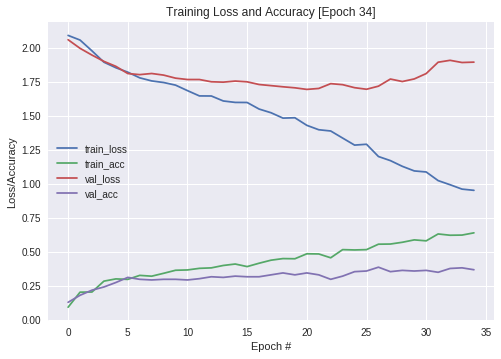

KeyboardInterrupt: 

In [95]:
model = build_model()
history = model.fit(x_train_exp, 
                    y_train, 
                    batch_size=1024, 
                    epochs=600,
                    validation_data = [x_test_exp, y_test], 
                    callbacks=[plot_losses], 
                    verbose=0)

In [130]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_101 (Conv1D)          (None, 259, 256)          1536      
_________________________________________________________________
activation_126 (Activation)  (None, 259, 256)          0         
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 259, 128)          163968    
_________________________________________________________________
activation_127 (Activation)  (None, 259, 128)          0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 259, 128)          0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 32, 128)           0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 32, 128)         

In [276]:
train_result = model.evaluate(x_train_exp, y_train, verbose=0)
test_result = model.evaluate(x_test_exp, y_test, verbose=0)

print("train acc","%s: %.2f%%" % (model.metrics_names[1], train_result[1]*100))
print("test acc","%s: %.2f%%" % (model.metrics_names[1], test_result[1]*100))

train acc accuracy: 100.00%
test acc accuracy: 25.82%


In [113]:
preds = model.predict(x_test_exp, batch_size=512, verbose=1)
preds_mod = preds.argmax(axis=1)
preds_flat = preds_mod.astype(int).flatten()
preds_transformed = (lb.inverse_transform((preds_flat)))
pred_df = pd.DataFrame({'predictedvalues': preds_transformed})
actual_values = y_test.argmax(axis=1)
actual_values_mod = actual_values.astype(int).flatten()
actual_values_mod_transformed = (lb.inverse_transform((actual_values_mod)))
actual_df = pd.DataFrame({'actualvalues': actual_values_mod_transformed})
final_df = actual_df.join(pred_df)
final_df.head(10)

213/213 [==============================] - 0s 862us/step


,actualvalues,predictedvalues
0,fearful,fearful
1,surprised,fearful
2,sad,angry
3,neutral,neutral
4,angry,angry
5,calm,disgusted
6,disgusted,disgusted
7,disgusted,disgusted
8,fearful,fearful
9,surprised,angry


In [114]:
final_df.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,35
calm,32
disgusted,38
fearful,22
happy,22
neutral,7
sad,33
surprised,24


In [115]:
final_df.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,56
calm,24
disgusted,47
fearful,28
happy,22
neutral,6
sad,14
surprised,16


In [116]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/hs/Desktop/Projects/speech_emotion_recognition/emotion-recognition/saved_models/Emotion_Voice_Detection_Model.h5 
